In [135]:
import numpy as np
import pandas as pd
import datetime
import os.path
import sys
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline 

In [136]:
totlenBTC = pd.read_csv('totalLendsBTC.csv').drop(['Timestamp'],axis = 1)
hist_price = pd.read_csv("vwapHourlyBTCUSD2.csv").drop(['Timestamp'],axis = 1)
totlenBTC = totlenBTC.rename(columns = {'Date':'datetime'})

In [137]:
totlenBTC['datetime'] = pd.to_datetime(totlenBTC['datetime'], infer_datetime_format = True).dt.floor('h')
hist_price['datetime'] = pd.to_datetime(hist_price['datetime'], infer_datetime_format = True).dt.ceil('h')

In [138]:
hist_price = hist_price.merge(totlenBTC, on = 'datetime', how = 'left').dropna()
hist_price.index = range(hist_price.shape[0])

In [139]:
hist_price.head()

,datetime,close,volume,Avg Rate (%/day),Total Amount Active Swaps (BTC),Used,Unused
0,2018-04-04 00:00:00,7412.472267,1043.970046,0.01940,57113.79520,56828.88481,284.91039
1,2018-04-03 23:00:00,7380.189997,1308.018265,0.01940,56952.16843,56671.44577,280.72267
2,2018-04-03 22:00:00,7404.486640,1116.924269,0.01939,56629.38249,56349.07010,280.31240
3,2018-04-03 21:00:00,7436.483644,1501.435002,0.01939,56620.50096,56340.28465,280.21631
4,2018-04-03 20:00:00,7479.585179,2094.046848,0.01939,56691.37902,56411.07760,280.30142


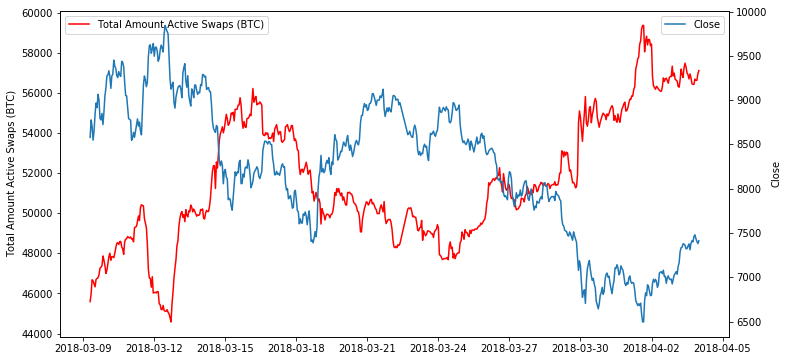

In [140]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(hist_price['datetime'],hist_price['Total Amount Active Swaps (BTC)'],'r')
ax.set_ylabel('Total Amount Active Swaps (BTC)')
ax2 = ax.twinx()
ax2.plot(hist_price['datetime'],hist_price['close'])
ax2.set_ylabel('Close')
ax.legend(['Total Amount Active Swaps (BTC)'])
ax2.legend(['Close'])

## Margin Strat

In [141]:
for i in [1,5,10,15,30]:
    hist_price['ma_'+str(i)] = hist_price[['Total Amount Active Swaps (BTC)']].rolling(window = i).mean()

In [169]:
hist_price['position'] = np.NaN
hist_price['fund'] = np.NaN

In [146]:
hist_price['fund'].iloc[0] = 10000
hist_price['position'].iloc[0] = 0

D:\Software\Anaconda\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [180]:
hist_price['signal'] = np.NaN
for idx in hist_price.index:
    if idx < 30:
        continue
    #if hist_price.loc[idx, ['close','ma_5','ma_15']].notna().all():
    if hist_price.loc[idx, 'ma_5'] < hist_price.loc[idx, 'ma_30'] and \
    hist_price.loc[idx-1, 'ma_5'] > hist_price.loc[idx-1, 'ma_30']:
        hist_price.loc[idx,'signal'] = 1

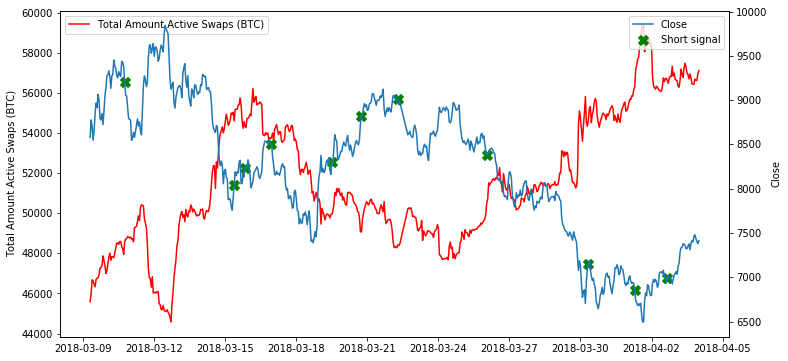

In [181]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(hist_price['datetime'],hist_price['Total Amount Active Swaps (BTC)'],'r')
ax.set_ylabel('Total Amount Active Swaps (BTC)')
ax2 = ax.twinx()
ax2.plot(hist_price['datetime'],hist_price['close'])
ax2.scatter(hist_price.loc[hist_price['signal'] == 1,'datetime'].values,
            hist_price.loc[hist_price['signal'] == 1,'close'].values,
           marker = 'X', c = 'g', s = 100)
ax2.set_ylabel('Close')
ax.legend(['Total Amount Active Swaps (BTC)'])
ax2.legend(['Close','Short signal'])